In [1]:
import eli5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder
from eli5.sklearn import PermutationImportance
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBRFClassifier, XGBClassifier
from jupyterthemes import jtplot

In [2]:
%matplotlib inline
jtplot.style(grid=False)
pd.set_option('display.max_columns', 500)

In [3]:
# test = pd.read_stata("C:\\Users\Paul\PycharmProjects\BlogPost\data\WA_BRFSS_11to17_B.dta",
#                      convert_missing=False)

In [4]:
%run -i main.py

In [5]:
df.head()

,Age,Race,Income,Over Median Income,Ownership,Total Household,Zip Code,In Food Desert,Employment,Active,Overweight,Pre Diabetic,Diabetic,Good Health,Fruit Daily,Veg Daily,Fruit Weekly,Veg Weekly,Fruit Monthly,Veg Monthly,Sleep Hrs,Insurance,Dr Too Much,Recent Dr Visit,Smoker,Alcohol UK,Alcohol Daily,Alcohol Weekly,Alcohol Monthly
90248,55-59,Don't\nKnow,$25-35K,False,Own,89.0,98233.0,False,Unknown,Unknown,Obese,False,True,Fair,False,True,True,False,False,False,NaN,Yes,No,Past Year,Former Smoker,False,False,True,False
51477,35-39,NaN,$50-75K,False,Own,90.0,98208.0,False,Unknown,Unknown,Obese,False,False,Good,True,False,False,True,False,False,NaN,Yes,No,Past Year,Former Smoker,False,False,True,False
33544,80-84,White,$15-20K,False,Own,90.0,98531.0,False,Unknown,Unknown,Obese,False,True,Good,False,True,False,False,True,False,8.0,Missing,Yes,Past Year,Former Smoker,True,False,False,False
1450,60-64,Hisp.,< $10K,False,Rent,89.0,98122.0,False,Unable to work,Does not meet Aerobic Recs,Over,True,False,Fair,False,False,False,False,False,False,NaN,No,No,Past Year,Current - Some Days,False,False,True,False
88263,18-24,Hisp.,$10-15K,False,Rent,91.0,98944.0,False,Unknown,Unknown,Under,False,False,Very Good,True,True,False,False,False,False,NaN,Yes,No,Past Year,Never Smoked,False,False,True,False


In [6]:
# df['Pre Diabetic'] = df['Pre Diabetic'].astype(int)
# df.describe()

In [7]:
def train_val_test_split(X, y):
    trainval, test, y_trainval, y_test = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          random_state=42,
                                                          )
    train, val, y_train, y_val = train_test_split(trainval,
                                                 y_trainval,
                                                 stratify=y_trainval,
                                                 random_state=42)
    return train, val, test, y_train, y_val, y_test

In [8]:
target = 'Diabetic'
y = df[target].astype(int)
X = df.drop(columns=target)

In [9]:
train, val, test, y_train, y_val, y_test = train_val_test_split(X, y)
train.shape, val.shape, test.shape, y_train.shape, y_val.shape, y_test.shape

((21834, 28), (7279, 28), (9705, 28), (21834,), (7279,), (9705,))

In [10]:
# Predict majority class as baseline.
y.value_counts(normalize=True)

0    0.889149
1    0.110851
Name: Diabetic, dtype: float64

In [11]:
y_true = y_train.astype(int)
roc_auc_score(y_true, np.full(y_train.shape, 0))

0.5

In [12]:
pipeline = make_pipeline(OrdinalEncoder(),
                         SimpleImputer())

In [13]:
X_train = pipeline.fit_transform(train)
X_val = pipeline.transform(val)
X_test = pipeline.transform(test)
X_train.shape, X_val.shape, X_test.shape

((21834, 28), (7279, 28), (9705, 28))

In [14]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [15]:
model = XGBRFClassifier(n_jobs=-1,
                        n_estimators=5000,
                        early_stopping_rounds=100,
                        random_state=42,
                        scale_pos_weight=15,
                        learning_rate=.005,
                        reg_lambda=.01,
                        verbosity=1)

In [16]:
model.fit(X_train,
          y_train,
          eval_set=eval_set,
          eval_metric='auc',
          verbose=True)

[0]	validation_0-auc:0.828286	validation_1-auc:0.810764


XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, early_stopping_rounds=100, gamma=0,
                learning_rate=0.005, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
                nthread=None, objective='binary:logistic', random_state=42,
                reg_alpha=0, reg_lambda=0.01, scale_pos_weight=15, seed=None,
                silent=None, subsample=0.8, verbosity=1)

Validation ROC AUC score: 0.8107638968665708


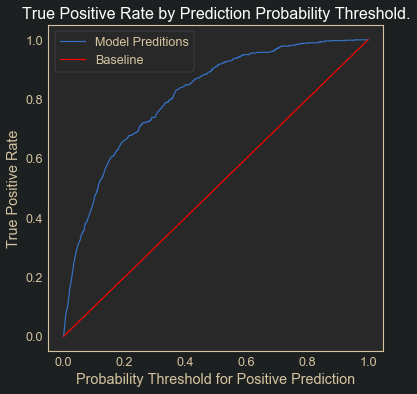

In [25]:
y_pred_proba = model.predict_proba(X_val)[:, 1]
print(f'Validation ROC AUC score: {roc_auc_score(y_val, y_pred_proba)}')
curves = roc_curve(y_val, y_pred_proba)
curve_x, curve_y = curves[0], curves[1]
x_ = np.linspace(0, 1, len(curve_x))
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
y_ = x_
plt.plot(curve_x, curve_y, label='Model Preditions')
plt.plot(x_, y_, color='red', label='Baseline')
plt.title('True Positive Rate by Prediction Probability Threshold.',
          fontsize=16,
          color='white')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('Probability Threshold for Positive Prediction')
plt.legend();

In [26]:
permuter = PermutationImportance(model,
                                 cv='prefit',
                                 n_iter=5,
                                 scoring='roc_auc',
                                 random_state=42)
permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBRFClassifier(base_score=0.5,
                                                colsample_bylevel=1,
                                                colsample_bynode=0.8,
                                                colsample_bytree=1,
                                                early_stopping_rounds=100,
                                                gamma=0, learning_rate=0.005,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1,
                                                missing=None, n_estimators=5000,
                                                n_jobs=-1, nthread=None,
                                                objective='binary:logistic',
                                                random_state=42, reg_alpha=0,
                                                reg_lambda=0.01,
                    

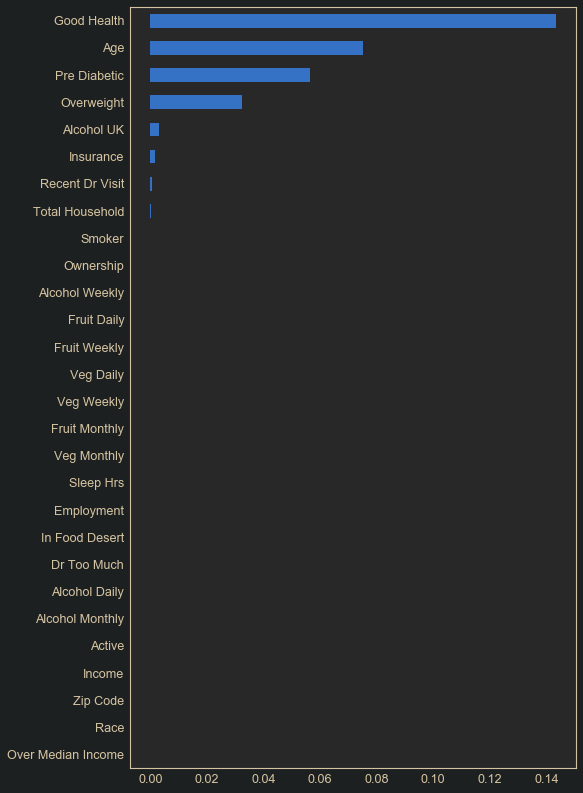

In [27]:
features_of_import = pd.Series(permuter.feature_importances_, val.columns)
plt.figure(figsize=(8, len(val.columns) / 2))
features_of_import.sort_values(ascending=True).plot.barh();

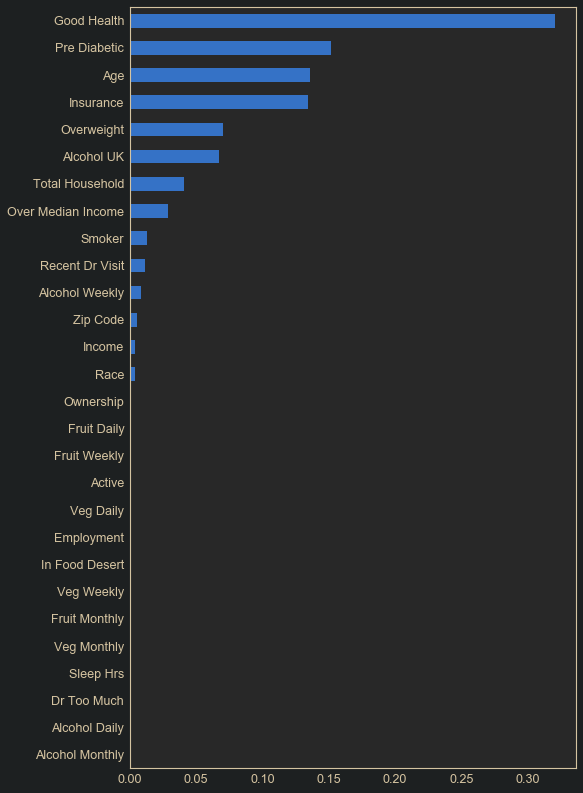

In [28]:
importance = pd.Series(model.feature_importances_, val.columns)
plt.figure(figsize=(8, len(val.columns) / 2))
importance.sort_values(ascending=True).plot.barh()


In [29]:
mask = features_of_import > 0
trimmed_columns = train.columns[mask]
train_trimmed = train[trimmed_columns]
val_trimmed = val[trimmed_columns]
test_trimmed = test[trimmed_columns]

pipeline1 = make_pipeline(OrdinalEncoder(),
                          SimpleImputer())

X_train_ = pipeline1.fit_transform(train_trimmed)
X_val_ = pipeline1.transform(val_trimmed)
X_test_ = pipeline1.transform(test_trimmed)

eval_set1 = [(X_train_, y_train),
            (X_val_, y_val)]

In [30]:
model.fit(X_train_, y_train, eval_set=eval_set1, eval_metric='auc')
y_pred_proba = model.predict_proba(X_val_)[:, 1]
print(f'XGBRFClassifier validation ROC AUC: {roc_auc_score(y_val, y_pred_proba)}')

[0]	validation_0-auc:0.827522	validation_1-auc:0.81016
XGBRFClassifier validation ROC AUC: 0.8101602097224074


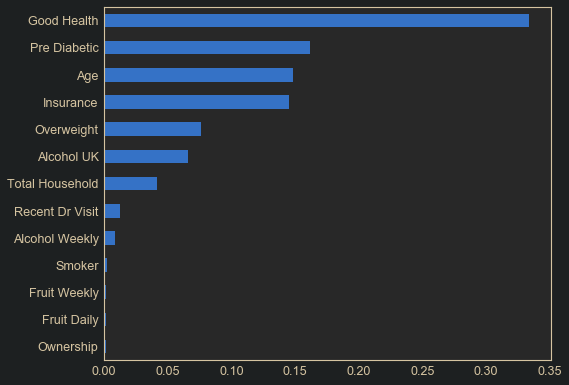

In [31]:
importance1 = pd.Series(model.feature_importances_, val_trimmed.columns)
plt.figure(figsize=(8, len(val_trimmed.columns) / 2))
importance1.sort_values(ascending=True).plot.barh()


In [32]:
model1 = RandomForestClassifier(n_estimators=500,
                                n_jobs=-1,
                                random_state=42)
model1.fit(X_train_, y_train, )
y_pred_proba1 = model1.predict_proba(X_val_)[:, 1]
print(f'RandomForestClassifier ROC AUC: {roc_auc_score(y_val, y_pred_proba1)}')

RandomForestClassifier ROC AUC: 0.7674222041990434


In [33]:
model2 = XGBClassifier(n_jobs=-1,
                       n_estimators=5000,
                       early_stopping_rounds=50,
                       random_state=42,
                       verbosity=0,
                       )
model2.fit(X_train_, y_train, eval_set=eval_set1, verbose=False, eval_metric='auc')
y_pred_proba2 = model2.predict_proba(X_val_)[:, 1]
print(f'XGBClassifier ROC AUC: {roc_auc_score(y_val, y_pred_proba2)}')

XGBClassifier ROC AUC: 0.8127012290480545


In [34]:
def nice_confusion(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='copper_r')

In [35]:
def set_threshold(y_true, y_pred_proba, threshold=.5003):
    
    print(f'Threshold: {threshold}')
    
    # Apply threshold to probabilies of positive prediction.
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1

    # Plot distribution of predicted probabilities.
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='r')
    plt.title('Distribution of predicted probabilities')
    plt.show()
    
    # Calculate true positive and false positive rates.
    true_pos = (y_pred == y_true) & (y_pred == class_1)
    false_pos = (y_pred != y_true) & (y_pred == class_1)
    actual_pos = y_true == class_1
    actual_neg = y_true == class_0
    true_pos_rate = true_pos.sum() / actual_pos.sum()
    false_pos_rate = false_pos.sum() / actual_neg.sum()
    print(f'True Positive Rate: {true_pos_rate}')
    print(f'False Positive Rate: {false_pos_rate}')
    
    # Plot ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    
    # Plot point for current threshold.
    plt.scatter(false_pos_rate, true_pos_rate)
    plt.show()
    
    print(f'Area under ROC: {roc_auc_score(y_true, y_pred_proba)}')
    
    nice_confusion(y_true, y_pred)
    print(classification_report(y_true, y_pred))


In [36]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba),
        threshold=(0.49, 0.51, 0.0001));

interactive(children=(FloatSlider(value=0.5003, description='threshold', max=0.51, min=0.49, step=0.001), Outp…

In [37]:
mask1 = importance > 0
trimmed_columns1 = train.columns[mask1]
train_trimmed1 = train[trimmed_columns1]
val_trimmed1 = val[trimmed_columns1]
test_trimmed1 = test[trimmed_columns1]

pipeline2 = make_pipeline(OrdinalEncoder(),
                          SimpleImputer())

X_train_1 = pipeline2.fit_transform(train_trimmed1)
X_val_1 = pipeline2.transform(val_trimmed1)
X_test_1 = pipeline2.transform(test_trimmed1)

eval_set1 = [(X_train_1, y_train),
            (X_val_1, y_val)]

In [38]:
model.fit(X_train_1, y_train, eval_set=eval_set1, eval_metric='auc')
y_pred_proba2 = model.predict_proba(X_val_1)[:, 1]
print(f'XGBRFClassifier validation ROC AUC: {roc_auc_score(y_val, y_pred_proba2)}')

[0]	validation_0-auc:0.827819	validation_1-auc:0.810339
XGBRFClassifier validation ROC AUC: 0.810338654510977


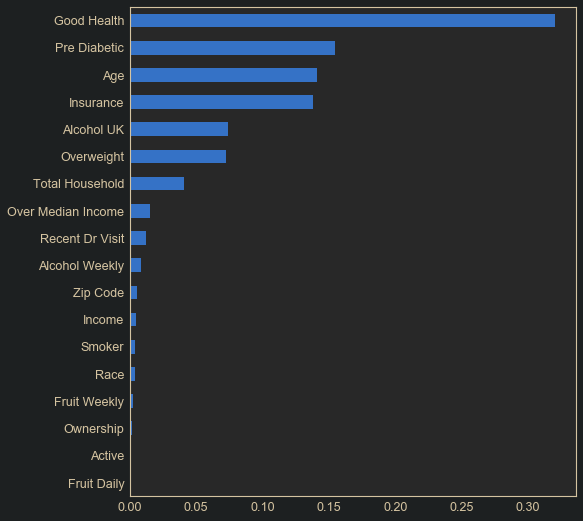

In [39]:
importance2 = pd.Series(model.feature_importances_, val_trimmed1.columns)
plt.figure(figsize=(8, len(val_trimmed1.columns) / 2))
importance2.sort_values(ascending=True).plot.barh()


In [40]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba2),
        threshold=(0.49, 0.51, 0.0001));

interactive(children=(FloatSlider(value=0.5003, description='threshold', max=0.51, min=0.49, step=0.0001), Out…